In [1]:
import gc
from collections import defaultdict
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import nibabel as nib
import numpy as np
import scipy.ndimage as ndimage
from matplotlib.colors import ListedColormap
from nilearn.image import load_img, math_img, new_img_like
from nilearn.plotting import plot_roi, plot_stat_map

from survey_medley_code.config_loader import load_config

# Reviewing the Results

This notebook shows the Omnibus F-test maps for questionnaire averages, both unadjusted and adjusted for question character count.

## Omnibus F-test
The Omnibus F-test detects whether there is any difference among the group means at a voxel level.

- Results are shown for both corrected and uncorrected questionnaire average activation estimates (*with or without adjustment for question character count*).
- Thresholding uses **TFCE p < 0.05**.
- A significant F indicates that some effect exists in the voxel, but does **not** specify which pairs differ.
- It can be significant even if none of the individual pre-defined pairwise contrasts reach the threshold — for example, when small, distributed differences combine to yield a significant F.

## Pairwise T-tests
Pairwise T-tests examine specific differences between two conditions/contrasts.

- These maps have been moved to `paired_t_test_maps.ipynb` in this directory.

## Pairwise T-test Conjunction Results (New)
I replaced the original T-test results with these conjunction results on 12/5/2025.

These maps examine **all possible conjunctions** of positive and negative significant results across the 10 pairwise comparisons.

- Individual paired comparisons are thresholded at **TFCE p < 0.05**.
- For conjunction maps containing at least one cluster of >400 voxels, the maps are overlaid on the Omnibus F-test map:
  - **Yellow** = F-test only  
  - **Blue** = Conjunction only  
  - **Green** = Both F-test and conjunction

## Notebook Layout
1. **Omnibus F-test results**  
2. **Relating paired T-test conjunctions to Omnibus F results**


In [2]:
cfg = load_config()
mask_path = (
    cfg.output_root / 'assess_subject_bold_dropout/group_mask_intersection_30pct.nii.gz'
)

In [3]:
outdir = cfg.output_root / 'within_subject_question_estimates'
outdir_adjusted = cfg.output_root / 'within_subject_adjusted_questionnaire_averages'

In [4]:
omnibus_pmap_file = outdir / 'group_f_test/glm_tfce_1minuspvalue_fstat_omnibusf.nii.gz'
omnibus_fmap_file = outdir / 'group_f_test/glm_fstat_omnibusf.nii.gz'

omnibus_pmap_file_adjusted = (
    outdir_adjusted / 'group_f_test/glm_tfce_1minuspvalue_fstat_omnibusf.nii.gz'
)
omnibus_fmap_file_adjusted = outdir_adjusted / 'group_f_test/glm_fstat_omnibusf.nii.gz'

paired_outdir = outdir / 'all_paired_t_tests'
paired_outdir_adjusted = outdir_adjusted / 'all_paired_t_tests'

### Functions

In [5]:
def get_p_t_maps(outdir):
    questionnaire_names = ['brief', 'future_time', 'grit', 'impulsive_venture', 'upps']
    question_pmaps = {}
    question_tmaps = {}

    for qa, qb in combinations(questionnaire_names, 2):
        pairing_name = f'{qa}_minus_{qb}'
        paired_pmap_loop = (
            outdir
            / f'paired_test_{pairing_name}/onesample_2sided_tfce_corrp_fstat1.nii.gz'
        )
        paired_t_loop = outdir / f'paired_test_{pairing_name}/uncorrected_tstat1.nii.gz'

        question_pmaps[pairing_name] = paired_pmap_loop
        question_tmaps[pairing_name] = paired_t_loop
    return question_pmaps, question_tmaps


def load_mask(mask_path):
    """Load mask and return 1D mask indices and affine/header info."""
    mask_nii = nib.load(mask_path)
    mask_data = mask_nii.get_fdata().astype(bool)
    mask_idx = np.where(mask_data)
    return mask_data, mask_idx, mask_nii.affine, mask_nii.header, mask_nii


def create_binary_matrix(tmap_dict, pmap_dict, mask_idx, p_threshold=0.1):
    """
    Create a binary matrix for positive and negative activations from dictionary of maps.

    Args:
        tmap_dict: dict, key = contrast name, value = tmap path
        pmap_dict: dict, key = contrast name, value = pmap path
        mask_idx: tuple of arrays, mask indices
        threshold: float, threshold for p-value maps (e.g., 0.9 for p<0.1)

    Returns:
        binary_matrix: np.array, shape (n_vox, n_contrasts*2)
        map_keys: list of strings labeling each column with sign-aware contrast
    """
    threshold = 1 - p_threshold
    contrast_names = list(tmap_dict.keys())
    n_vox = len(mask_idx[0])
    n_contrasts = len(contrast_names)

    binary_matrix = np.zeros((n_vox, n_contrasts * 2), dtype=np.uint8)
    map_keys = []

    for i, contrast in enumerate(contrast_names):
        tmap_data = nib.load(tmap_dict[contrast]).get_fdata()[mask_idx]
        pmap_data = nib.load(pmap_dict[contrast]).get_fdata()[mask_idx]

        # Parse A-B from key
        a, b = contrast.split('_minus_')

        # Positive activation
        pos = (tmap_data > 0) & (pmap_data > threshold)
        binary_matrix[:, 2 * i] = pos.astype(np.uint8)
        map_keys.append(f'{b} < {a}')  # swap for positive sign

        # Negative activation
        neg = (tmap_data < 0) & (pmap_data > threshold)
        binary_matrix[:, 2 * i + 1] = neg.astype(np.uint8)
        map_keys.append(f'{a} < {b}')  # keep order for negative sign

        # Clean up
        del tmap_data, pmap_data, pos, neg

    return binary_matrix, map_keys


def integer_conjunction_map(binary_matrix, map_labels=None):
    """
    Convert a binary matrix of voxel activations to integer-encoded conjunctions.

    Args:
        binary_matrix: np.array of shape (n_vox, n_maps), 0/1 values
        map_labels: optional list of length n_maps, names of hypotheses

    Returns:
        integer_map: np.array of shape (n_vox,), each voxel encoded as an integer
        key_map: dict mapping integer -> list of active hypotheses (indices or labels)
    """
    n_vox, n_cols = binary_matrix.shape
    powers = 2 ** np.arange(n_cols, dtype=np.int32)

    # Encode each voxel's active maps as a single integer
    integer_map = binary_matrix.dot(powers)

    # Build key map: integer -> active map indices/labels
    unique_vals = np.unique(integer_map)
    key_map = {}
    for val in unique_vals:
        if val == 0:
            key_map[val] = []
        else:
            # Find which bits are set
            cols = np.where(((val >> np.arange(n_cols)) & 1) == 1)[0]
            if map_labels is not None:
                key_map[val] = [map_labels[i] for i in cols]
            else:
                key_map[val] = cols.tolist()

    return integer_map, key_map


def plot_integer_map_overlay(
    integer_map,
    mask_data,
    mask_idx,
    key_map,
    z_slices,
    mask_nifti,
    omnibus_pmap_file,
    omnibus_threshold=0.05,
    min_cluster_vox=200,
):
    """
    Plot clusters with overlap using integer values and a custom colormap:
    0 = background, 1 = cluster only, 2 = omnibus only, 3 = overlap
    """
    # Reconstruct 3D integer map
    img_3d = np.zeros(mask_data.shape, dtype=np.int32)
    img_3d[mask_idx] = integer_map

    # Load and threshold omnibus F-test map
    omnibus_img = nib.load(omnibus_pmap_file)
    omnibus_data = omnibus_img.get_fdata()
    omnibus_binary = (omnibus_data > (1 - omnibus_threshold)).astype(np.int32)

    # Define colormap
    cmap = ListedColormap(['black', 'blue', 'lemonchiffon', 'limegreen'])

    for val, cols in key_map.items():
        if val == 0:
            continue  # skip empty voxels

        cluster_map = (img_3d == val).astype(np.int32)
        if np.sum(cluster_map) == 0:
            continue  # skip if no voxels for this val

        # Label connected components
        labeled_clusters, n_clusters = ndimage.label(cluster_map)

        for cl in range(1, n_clusters + 1):
            n_vox = np.sum(labeled_clusters == cl)
            if n_vox < min_cluster_vox:
                continue

            cluster_bin = (labeled_clusters == cl).astype(np.int32)

            # Create single integer overlay image
            overlay_int = np.zeros(cluster_bin.shape, dtype=np.int32)
            overlay_int[cluster_bin == 1] = 1  # cluster only
            overlay_int[(omnibus_binary == 1) & (cluster_bin == 0)] = 2  # omnibus only
            overlay_int[(cluster_bin == 1) & (omnibus_binary == 1)] = 3  # overlap

            overlay_nifti = nib.Nifti1Image(overlay_int, affine=mask_nifti.affine)
            label_text = f'Hypotheses: {cols}'
            display = plot_stat_map(
                overlay_nifti,
                display_mode='z',
                cut_coords=z_slices,
                title=f'{label_text} ({n_vox} voxels)',
                colorbar=False,
                cmap=cmap,
                symmetric_cbar=False,
            )
            plt.show()
            del overlay_int, overlay_nifti, cluster_bin


# ---------------------------
# Step 1-3: full pipeline
# ---------------------------


def process_pairwise_maps(
    tmap_paths,
    pmap_paths,
    omnibus_pmap_file,
    mask_path,
    z_slices,
    t_threshold=0.05,
    omnibus_f_threshold=0.05,
    min_cluster_vox=200,
):
    mask_data, mask_idx, affine, header, mask_nii = load_mask(mask_path)

    binary_matrix, map_keys = create_binary_matrix(
        question_tmaps, question_pmaps, mask_idx, t_threshold
    )

    integer_map, integer_keys = integer_conjunction_map(binary_matrix, map_keys)

    plot_integer_map_overlay(
        integer_map,
        mask_data,
        mask_idx,
        integer_keys,
        z_slices,
        mask_nii,
        omnibus_pmap_file,
        omnibus_threshold=omnibus_f_threshold,
        min_cluster_vox=min_cluster_vox,
    )


## 1. Omnibus F-test results

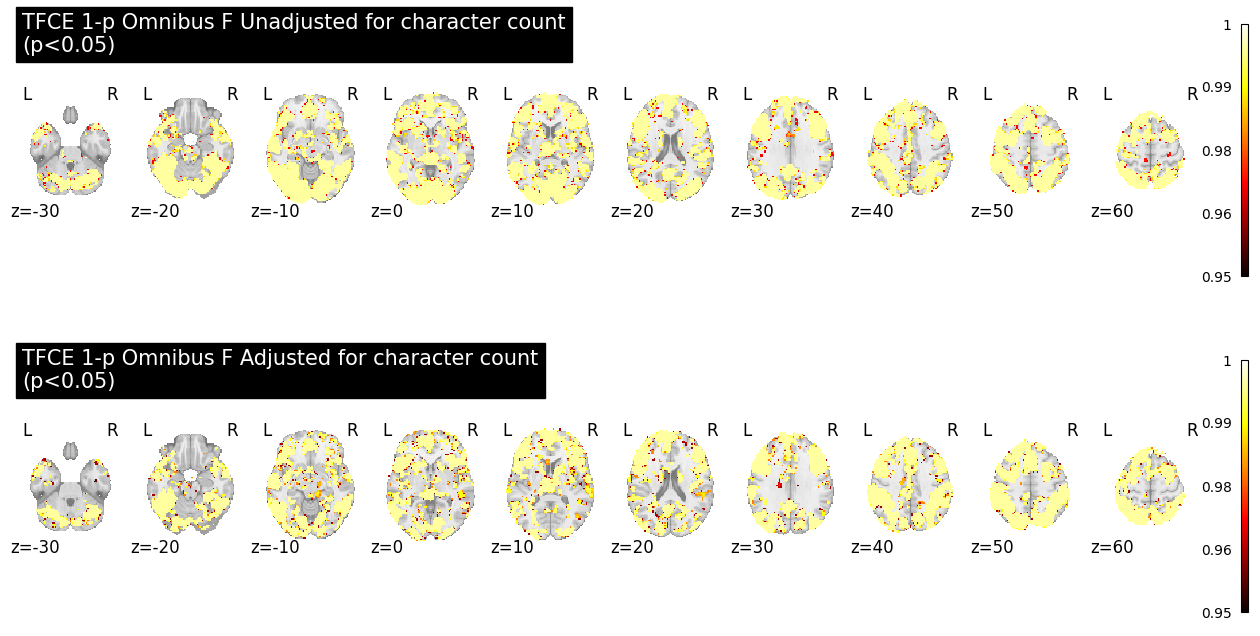

In [6]:
# omnibus = load_img(omnibus_pmap_file)

z_slices = list(range(-30, 61, 10))
threshold = 0.95

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

plot_stat_map(
    omnibus_pmap_file,
    threshold=threshold,
    display_mode='z',
    cut_coords=z_slices,
    colorbar=True,
    vmin=0.95,
    vmax=1.005,
    symmetric_cbar=False,
    cmap='hot',
    title=f'TFCE 1-p Omnibus F Unadjusted for character count\n(p<{(1 - threshold):.2f})',
    axes=axes[0],
)

plot_stat_map(
    omnibus_pmap_file_adjusted,
    threshold=threshold,
    display_mode='z',
    cut_coords=z_slices,
    colorbar=True,
    vmin=0.95,
    vmax=1.005,
    symmetric_cbar=False,
    cmap='hot',
    title=f'TFCE 1-p Omnibus F Adjusted for character count\n(p<{(1 - threshold):.2f})',
    axes=axes[1],
)
plt.show()

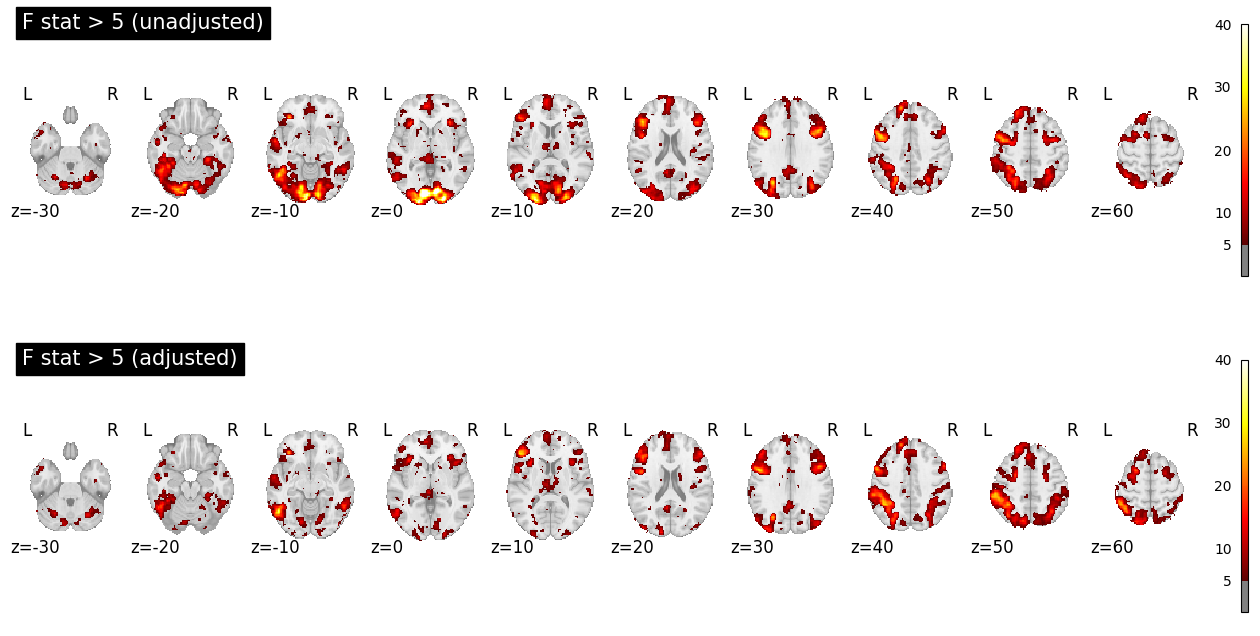

In [7]:
fthresh = 5


maps = [omnibus_fmap_file, omnibus_fmap_file_adjusted]
labels = [f'F stat > {fthresh} (unadjusted)', f'F stat > {fthresh} (adjusted)']

fig, axes = plt.subplots(2, 1, figsize=(16, 8))
for ind, (map, label) in enumerate(zip(maps, labels)):
    plot_stat_map(
        map,
        threshold=fthresh,
        display_mode='z',
        cut_coords=z_slices,
        colorbar=True,
        title=label,
        vmin=0,
        vmax=40,
        symmetric_cbar=False,
        cmap='hot',
        axes=axes[ind],
    )

plt.show()

## 2. Conjunction Results

The code calculates all possible conjunctions between the 20 maps (positive and negative significance for each of the 10 paired comparisons) and for conjunction maps with at least 1 cluster with >400 voxels, the conjunction map is displayed on top of the f-test significance maps.  All of thes maps are binary (significant or not) and so I've coded the maps:
  - **Yellow** = F-test only  
  - **Blue** = Conjunction only  
  - **Green** = Both F-test and conjunction

The first set of maps corresponds to the tests using the questionnaire averages that are not adjusted for question character count and the second set of maps use the adjusted questionnaire averages.

In [8]:
question_pmaps, question_tmaps = get_p_t_maps(paired_outdir)
question_pmaps_adjusted, question_tmaps_adjusted = get_p_t_maps(paired_outdir_adjusted)

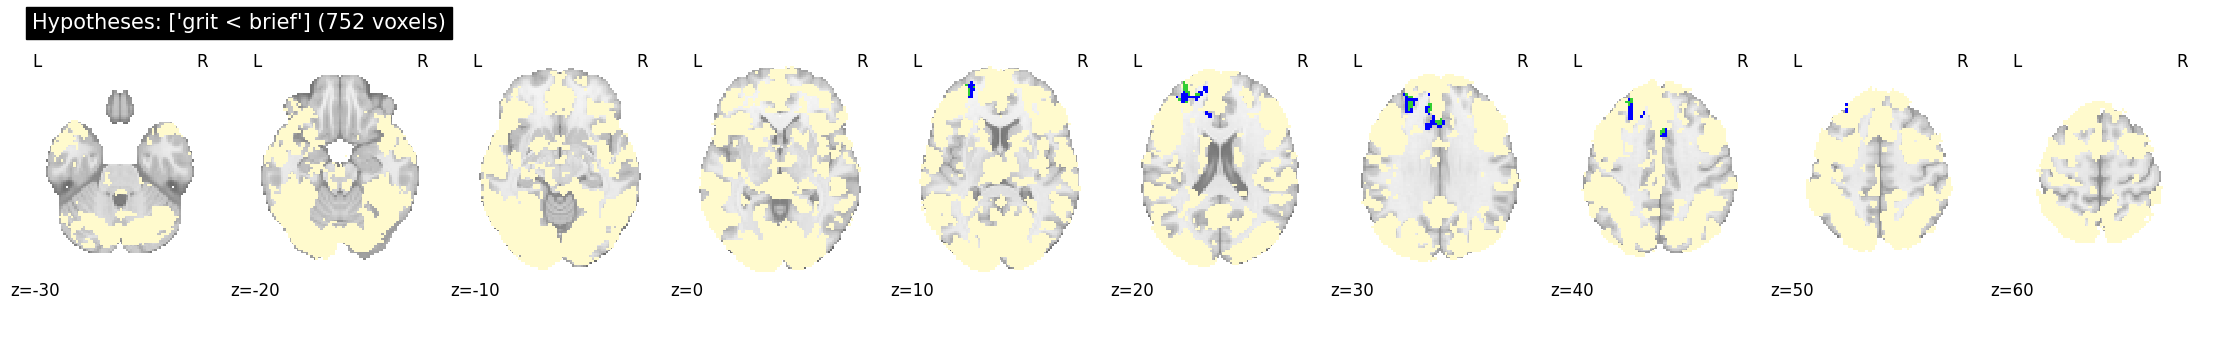

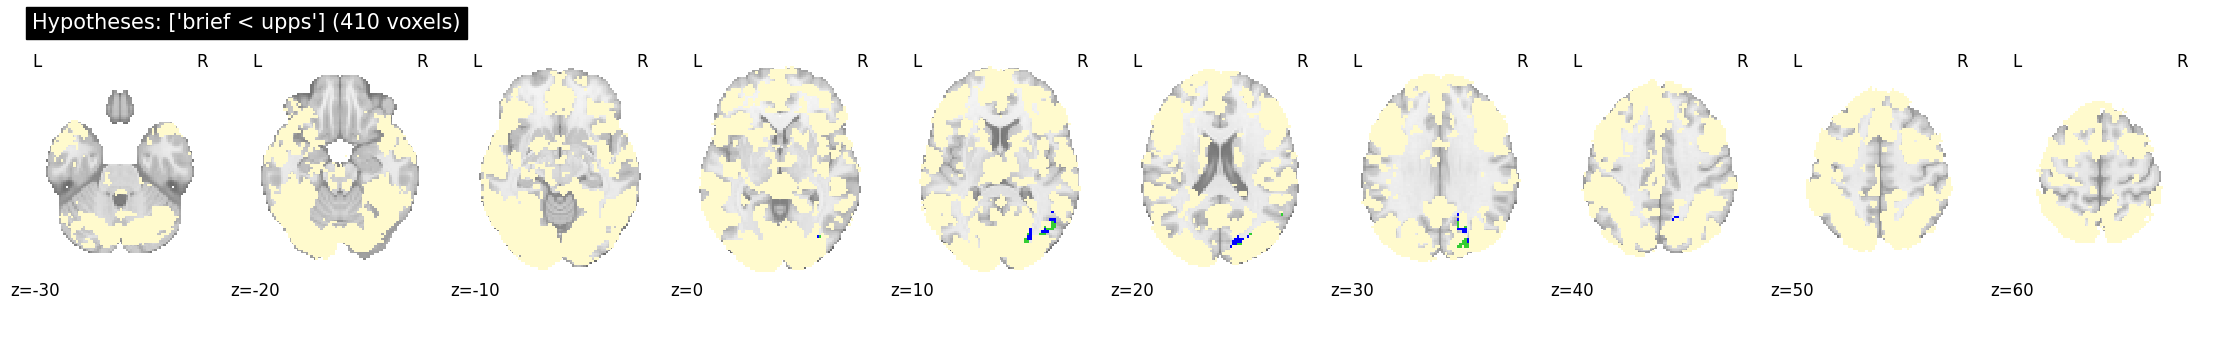

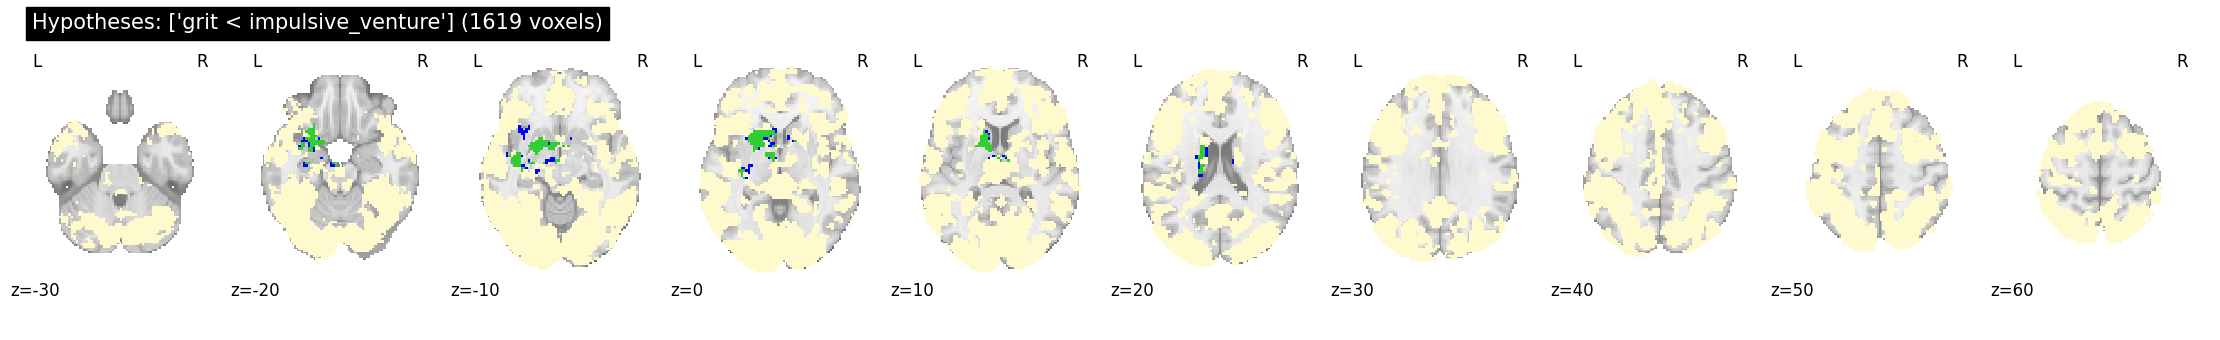

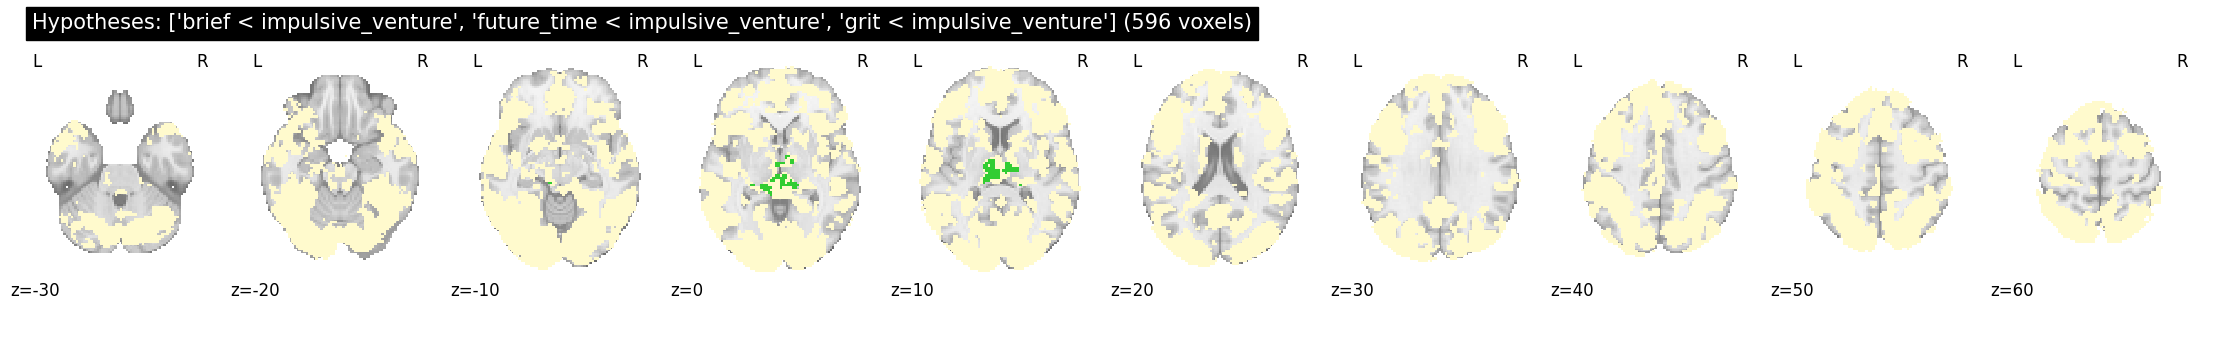

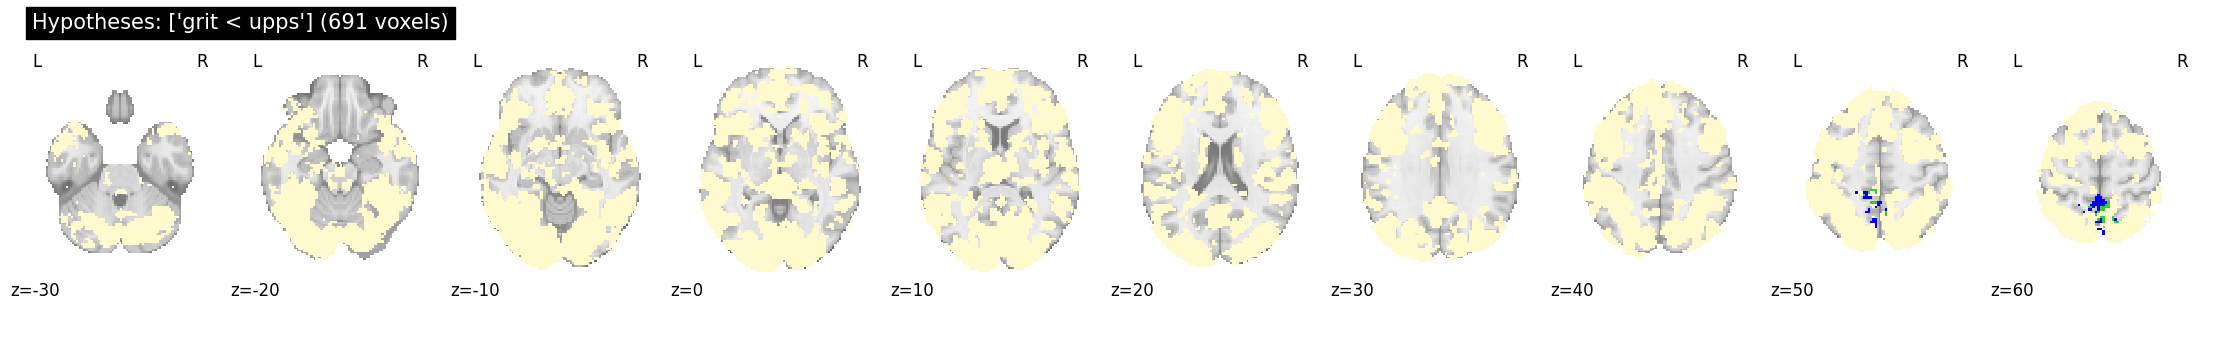

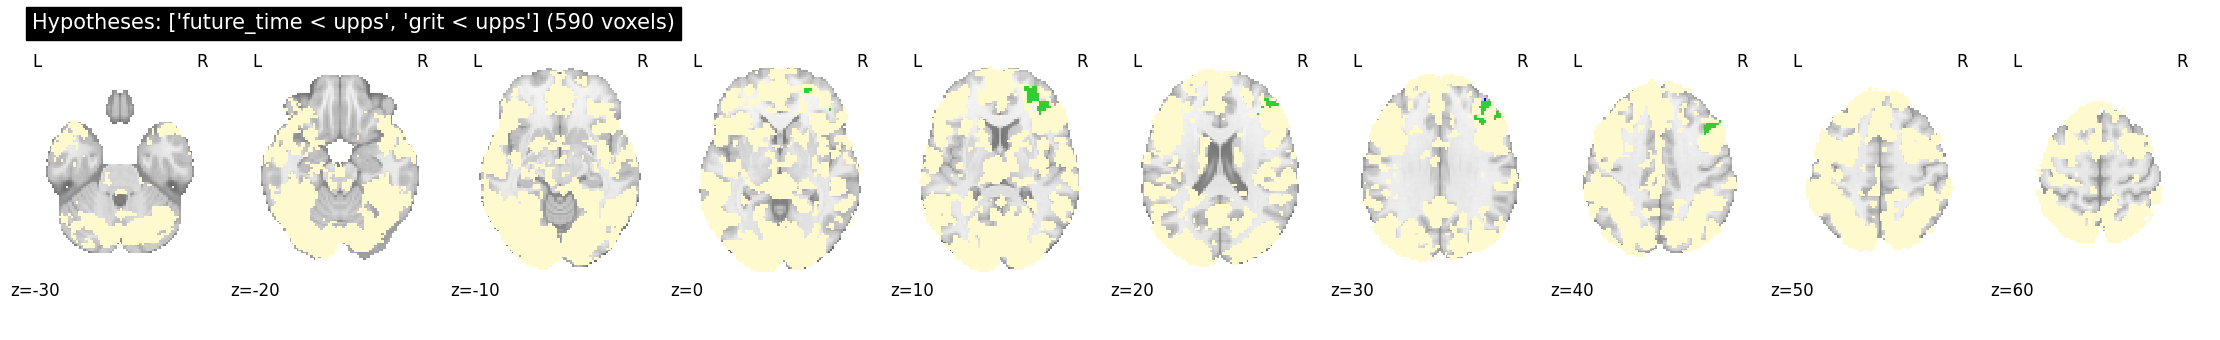

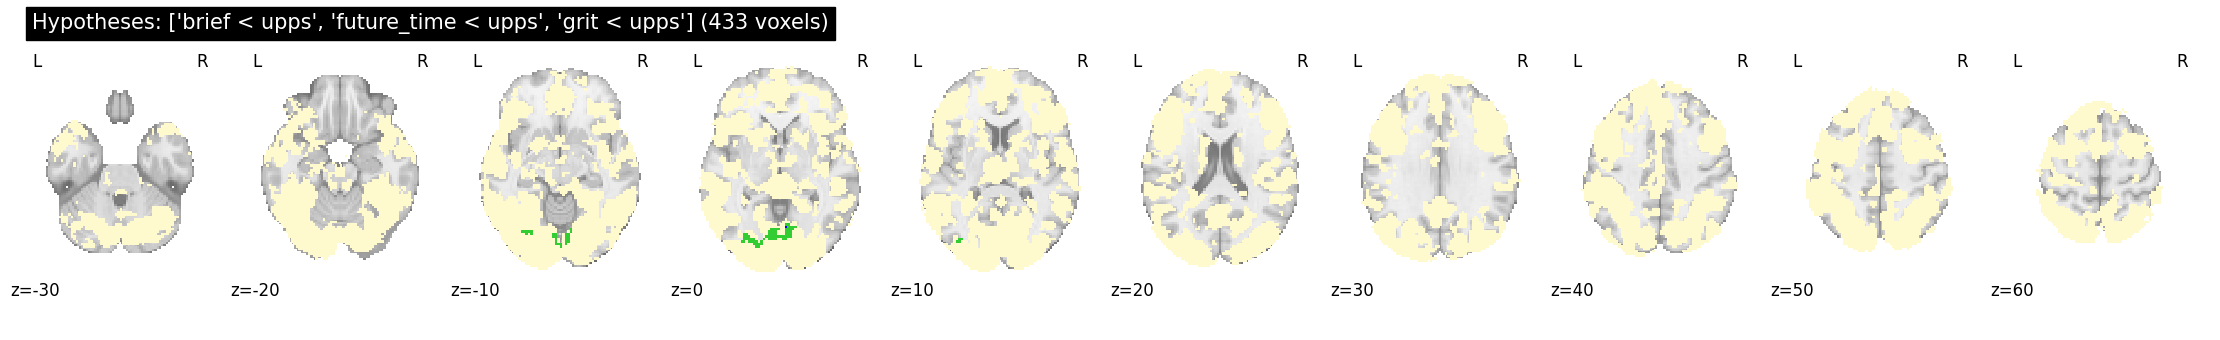

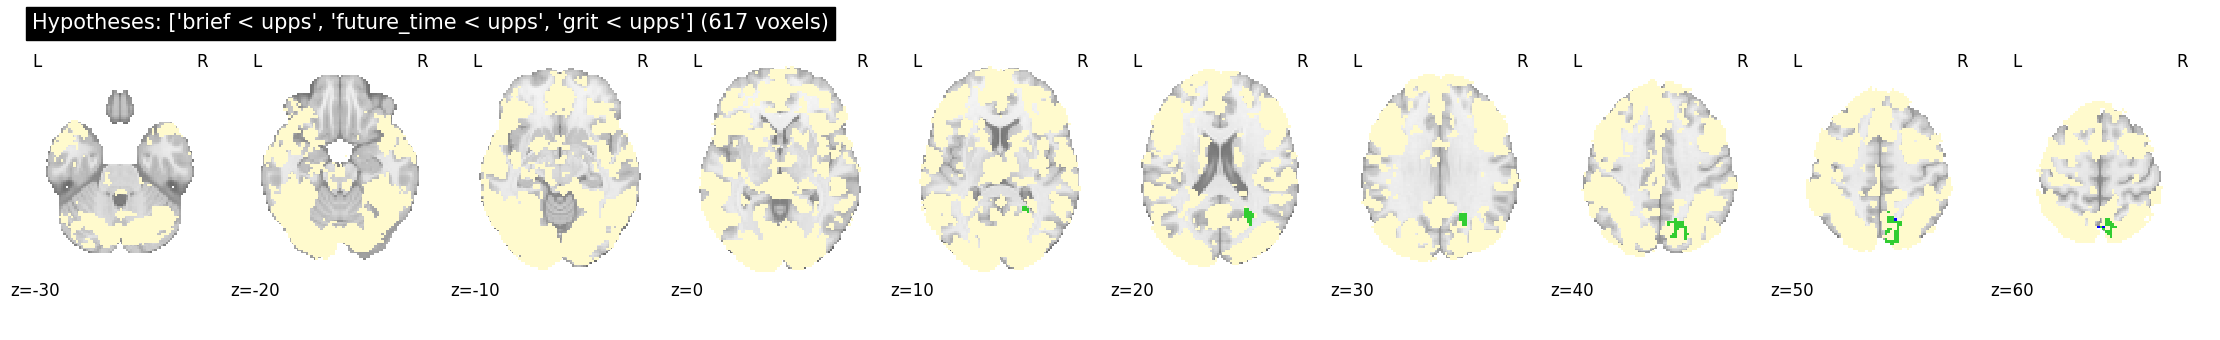

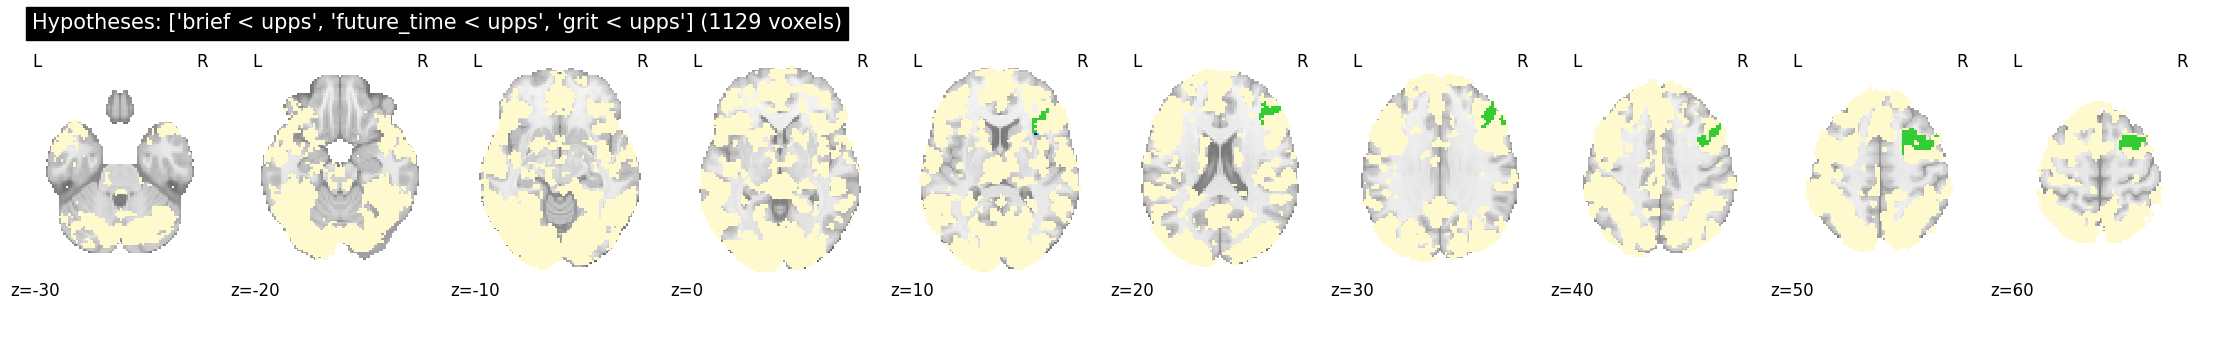

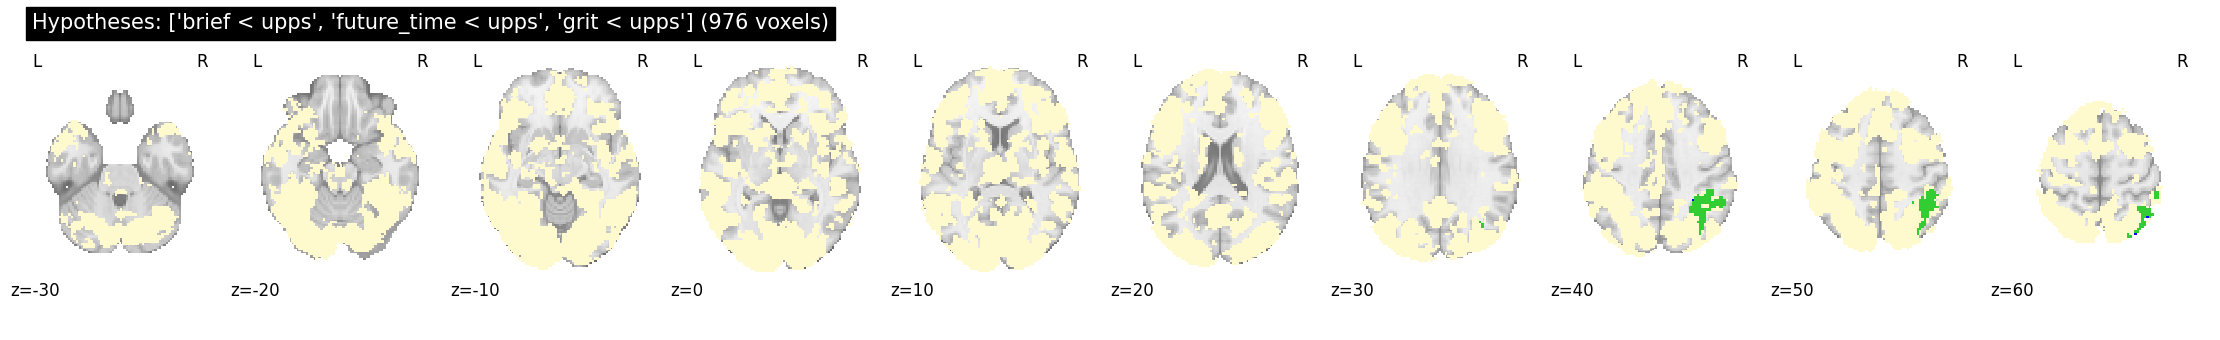

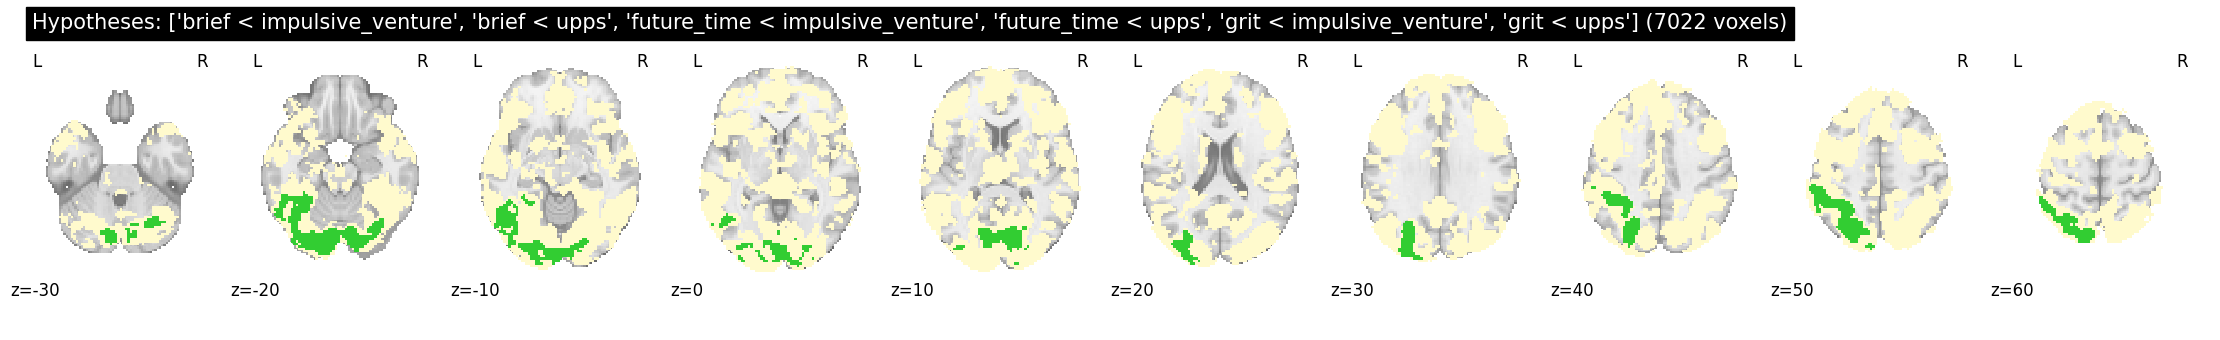

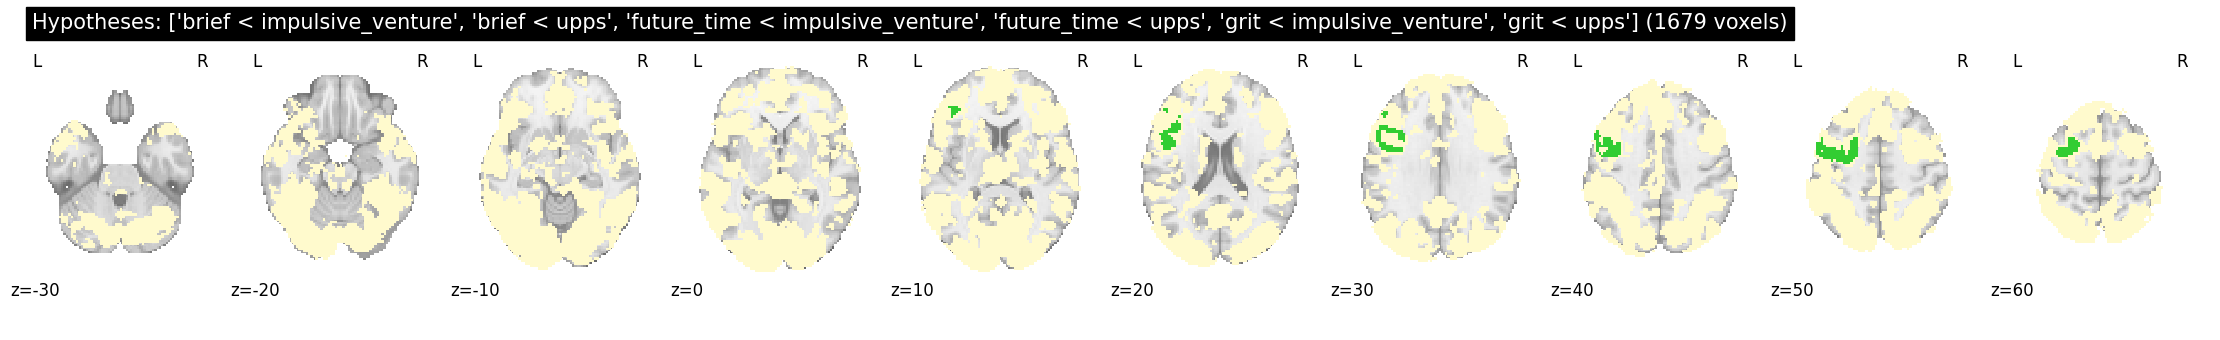

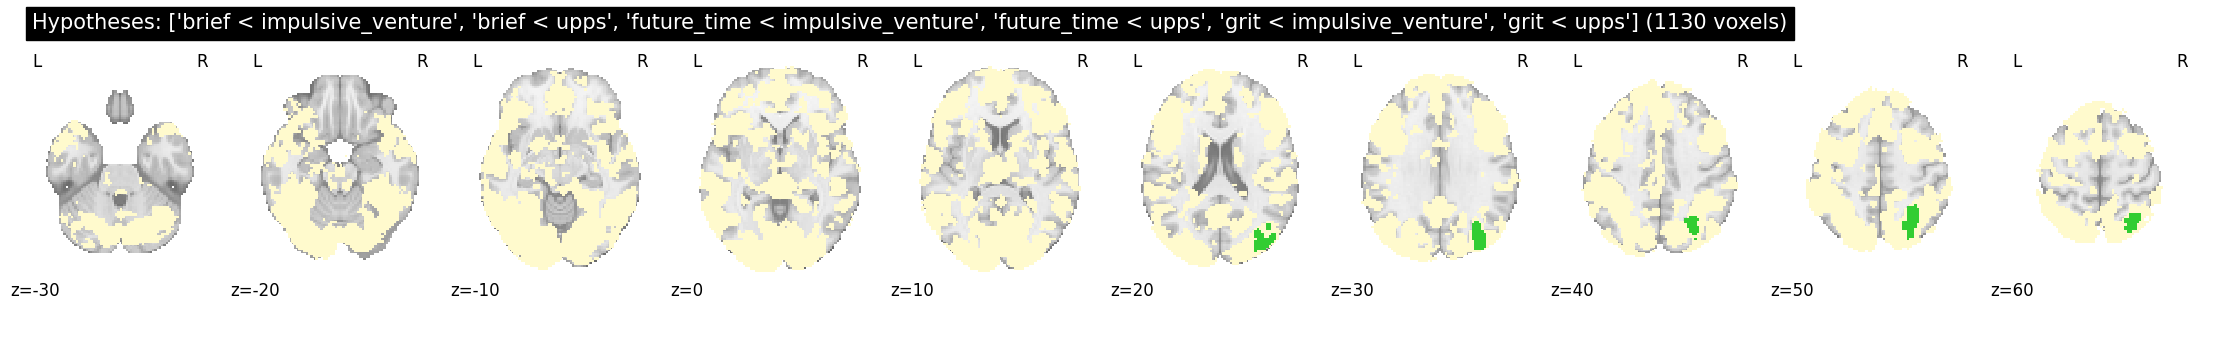

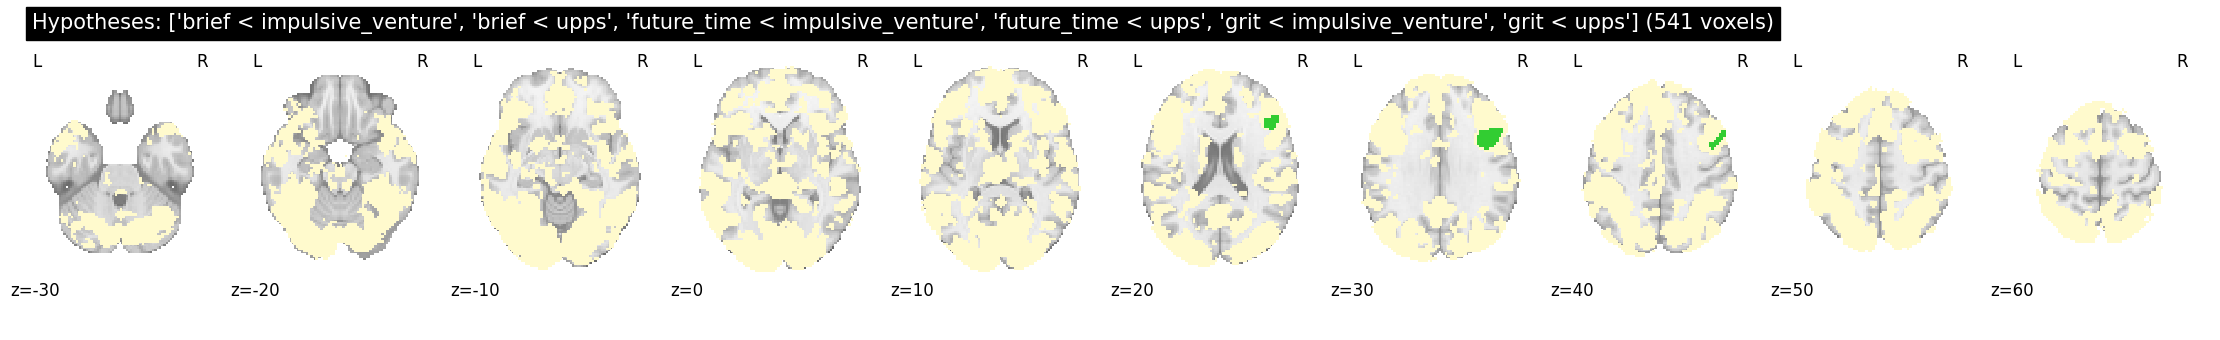

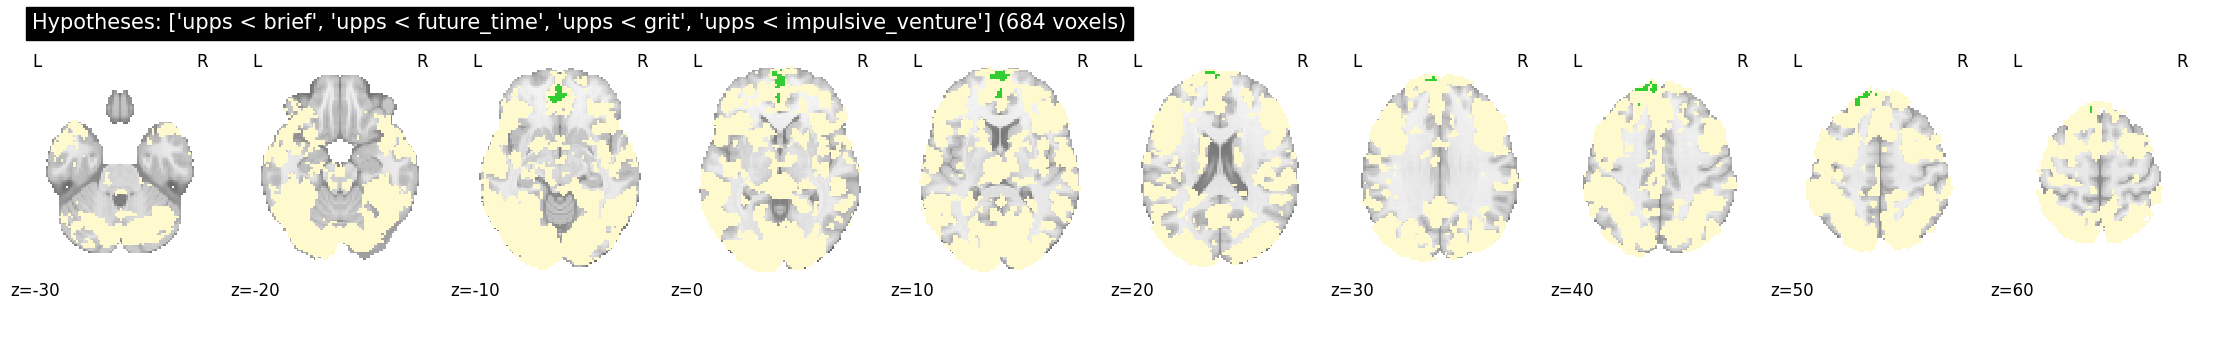

In [9]:
process_pairwise_maps(
    question_tmaps,
    question_pmaps,
    omnibus_pmap_file,
    mask_path,
    z_slices,
    t_threshold=0.05,
    omnibus_f_threshold=0.05,
    min_cluster_vox=400,
)

### Repeat with Adjusted data
The adjustment is for the number of characters within each question

  - **Yellow** = F-test only  
  - **Blue** = Conjunction only  
  - **Green** = Both F-test and conjunction

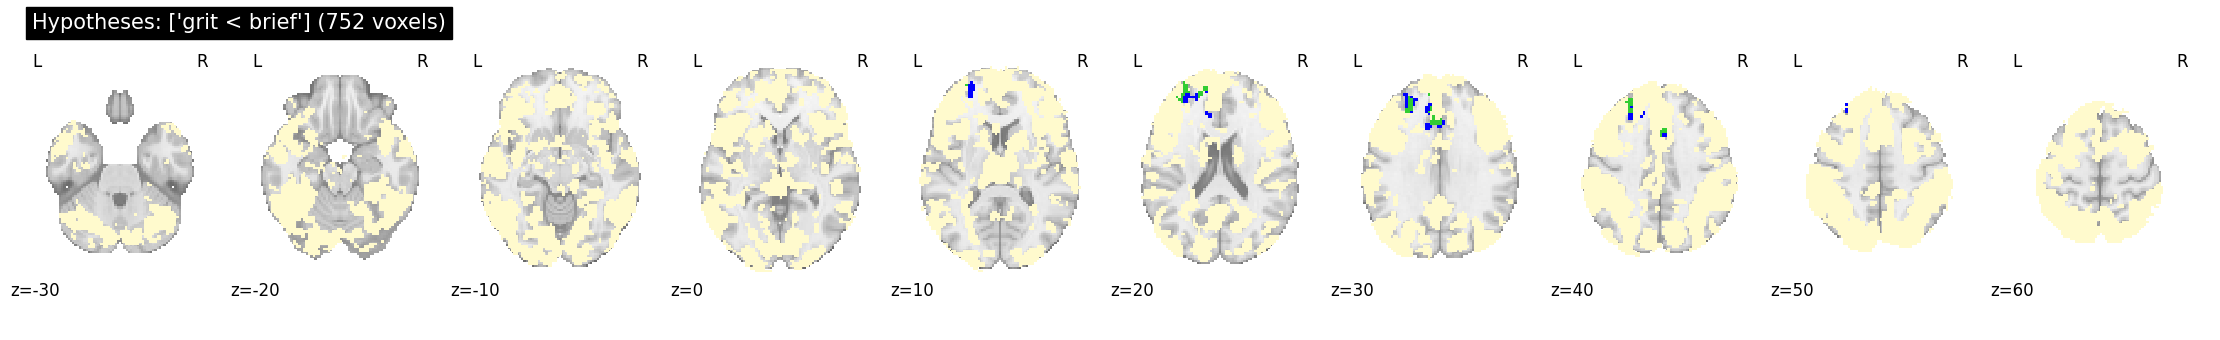

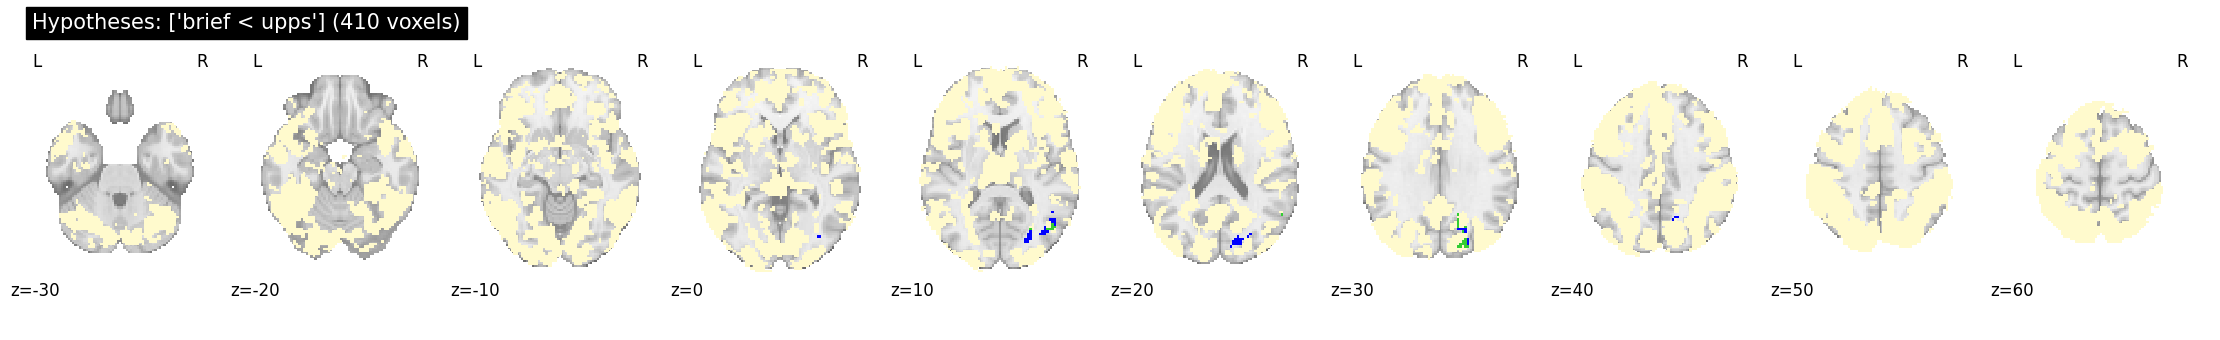

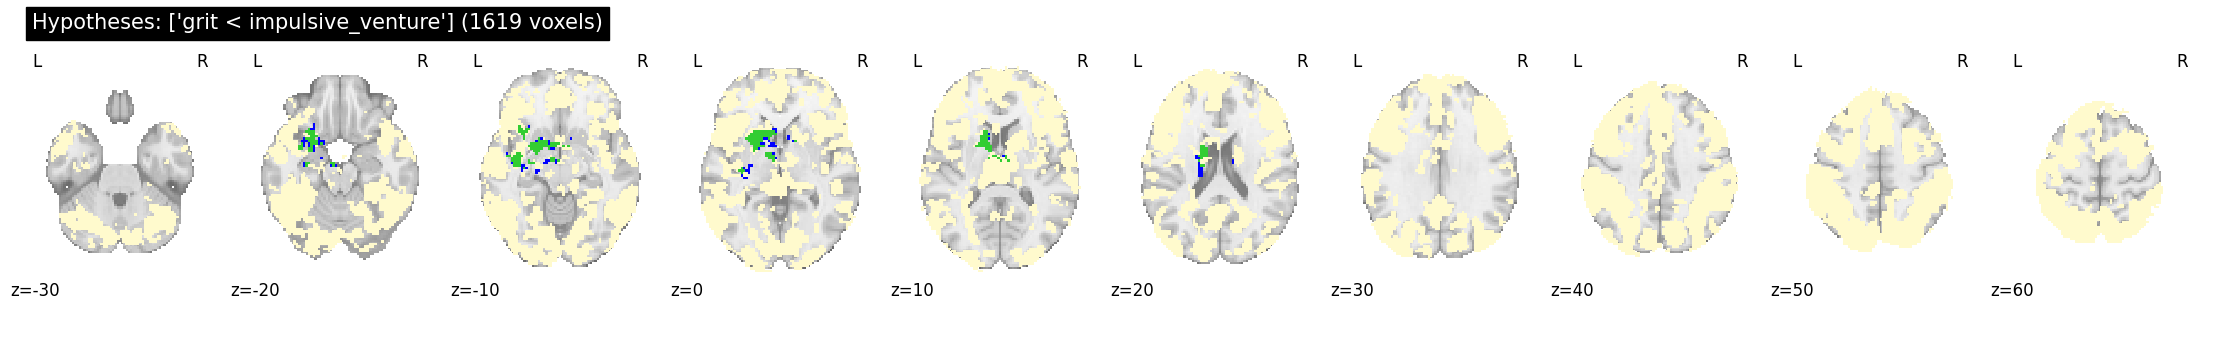

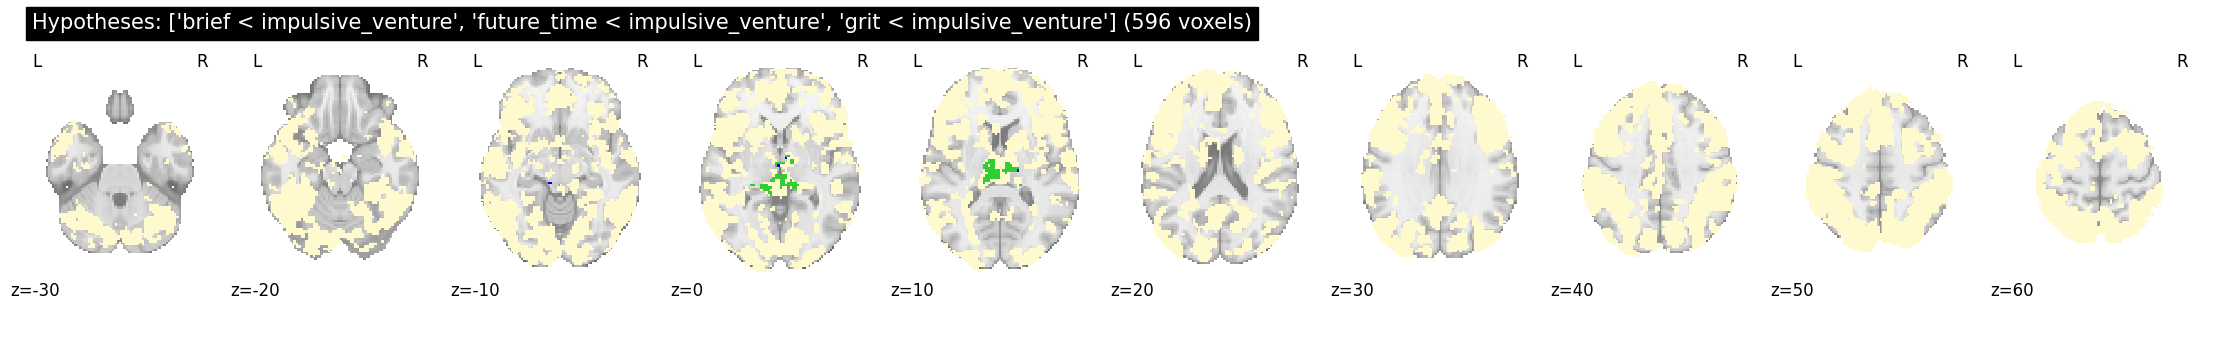

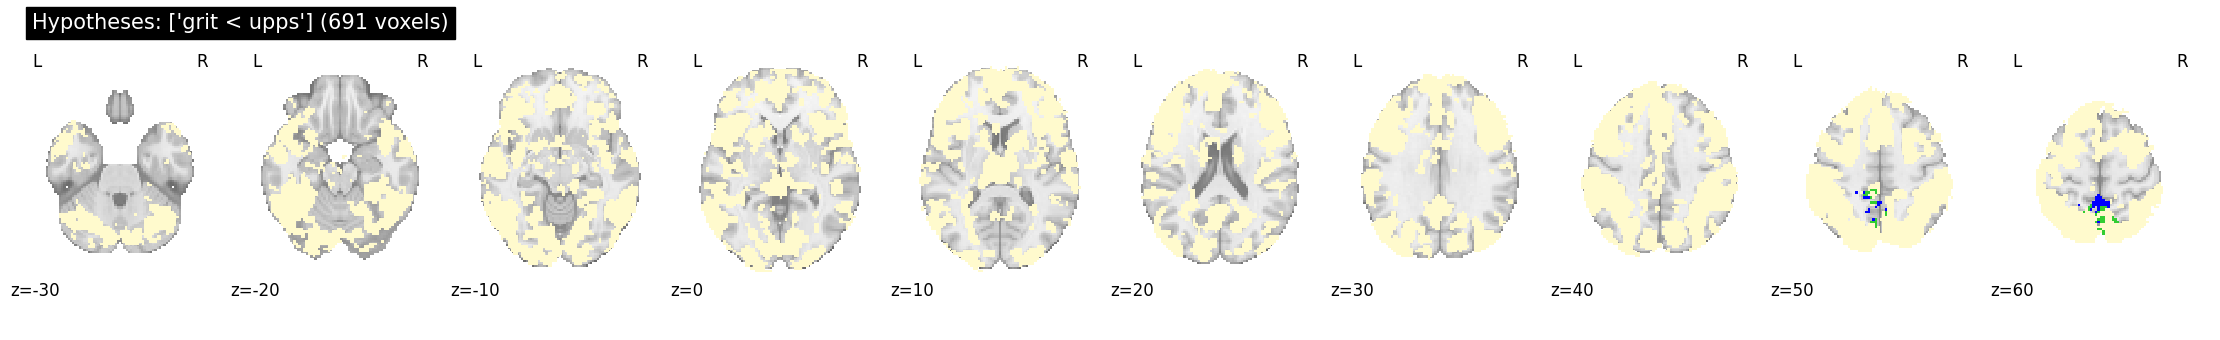

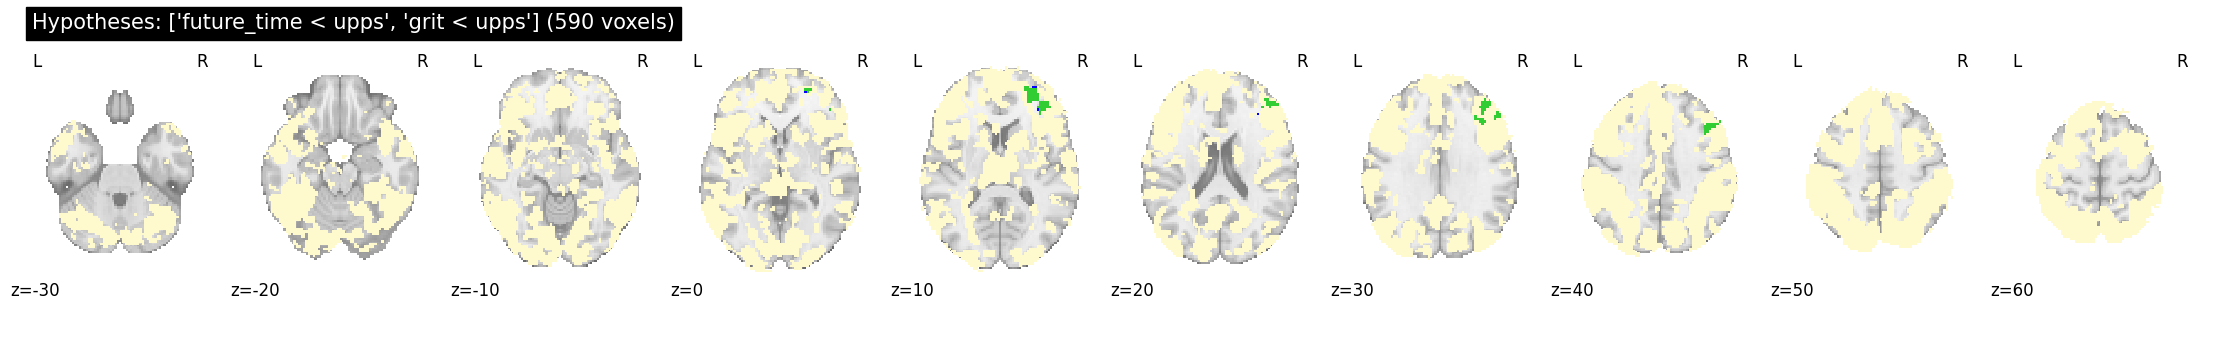

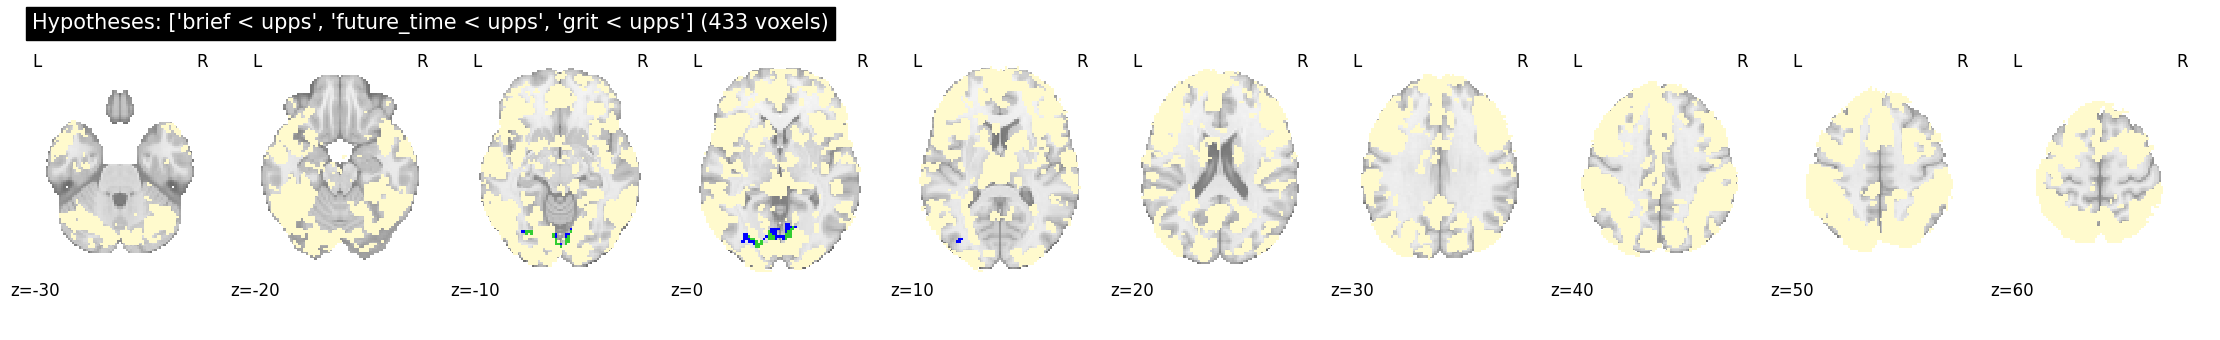

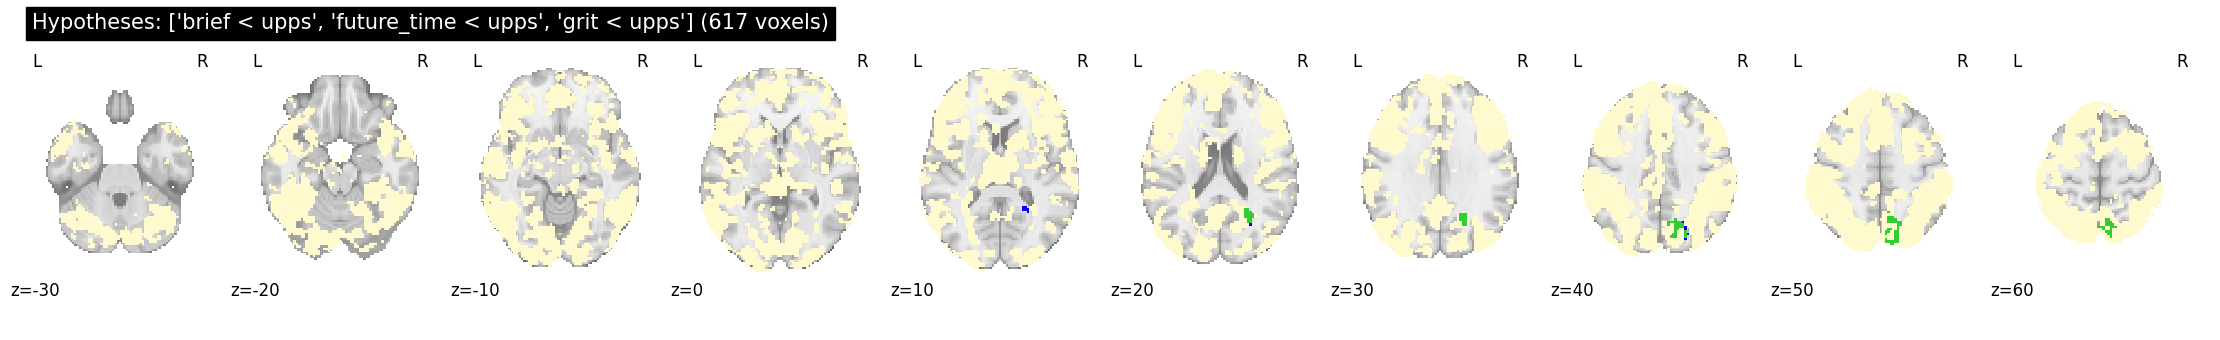

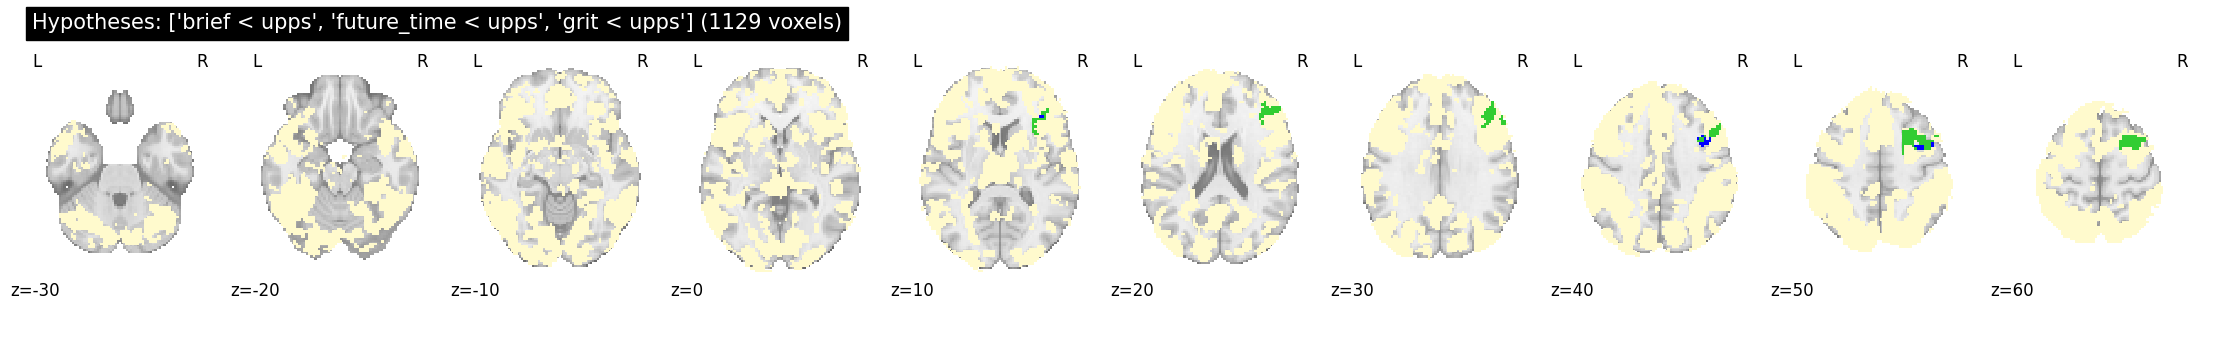

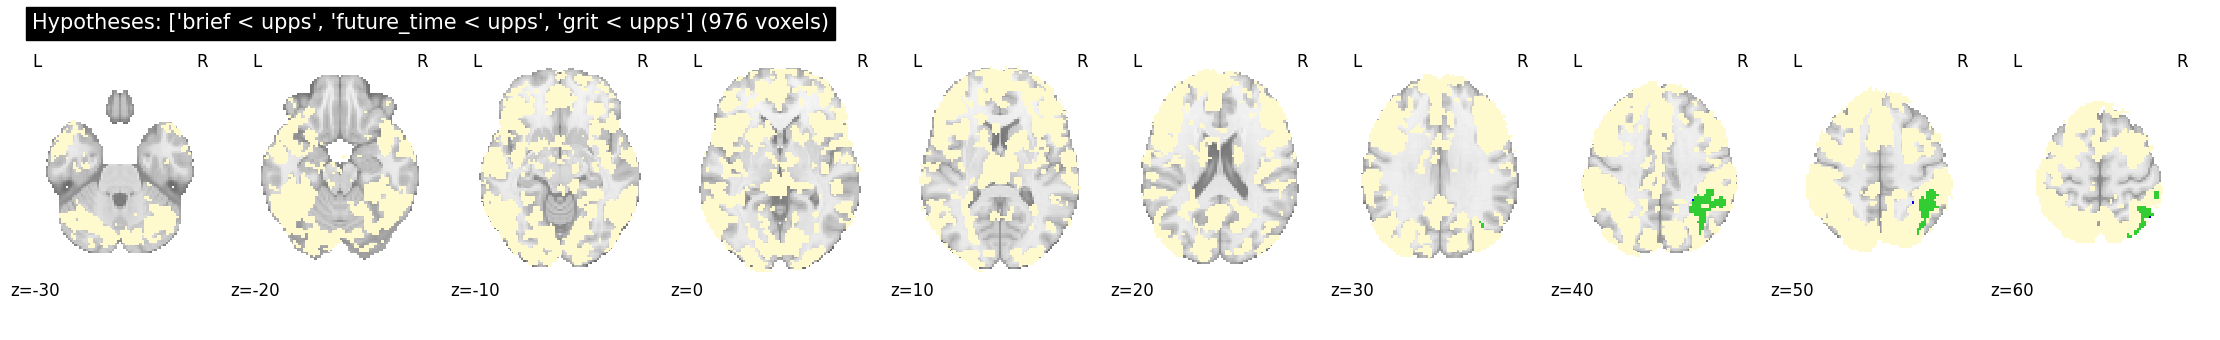

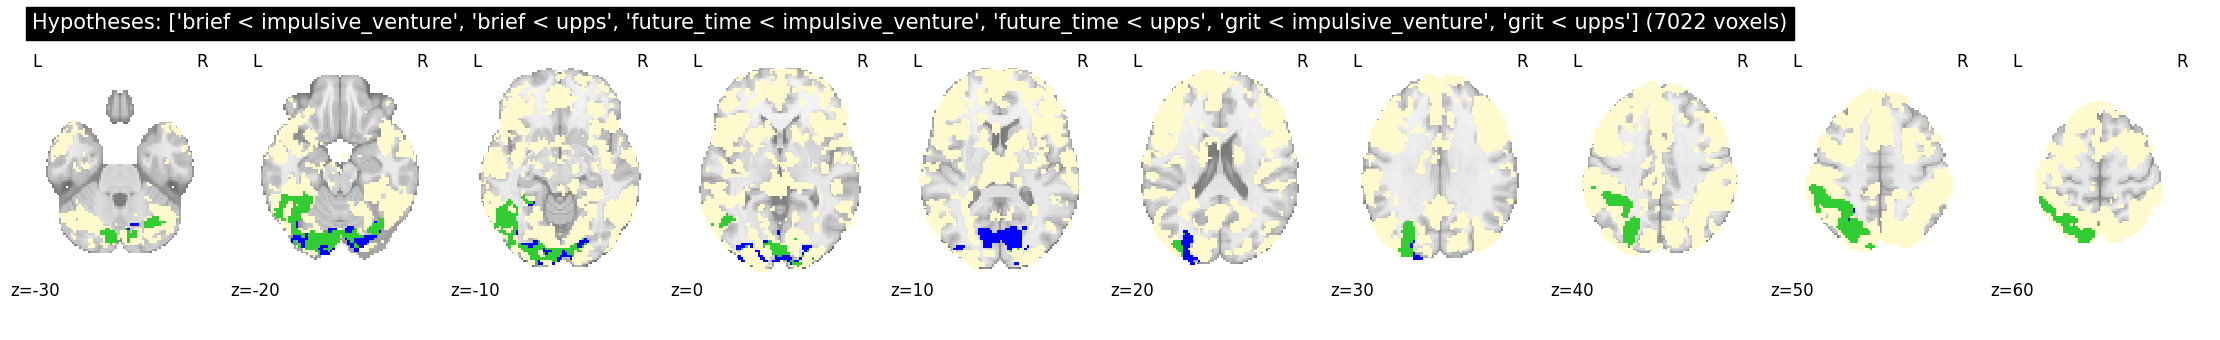

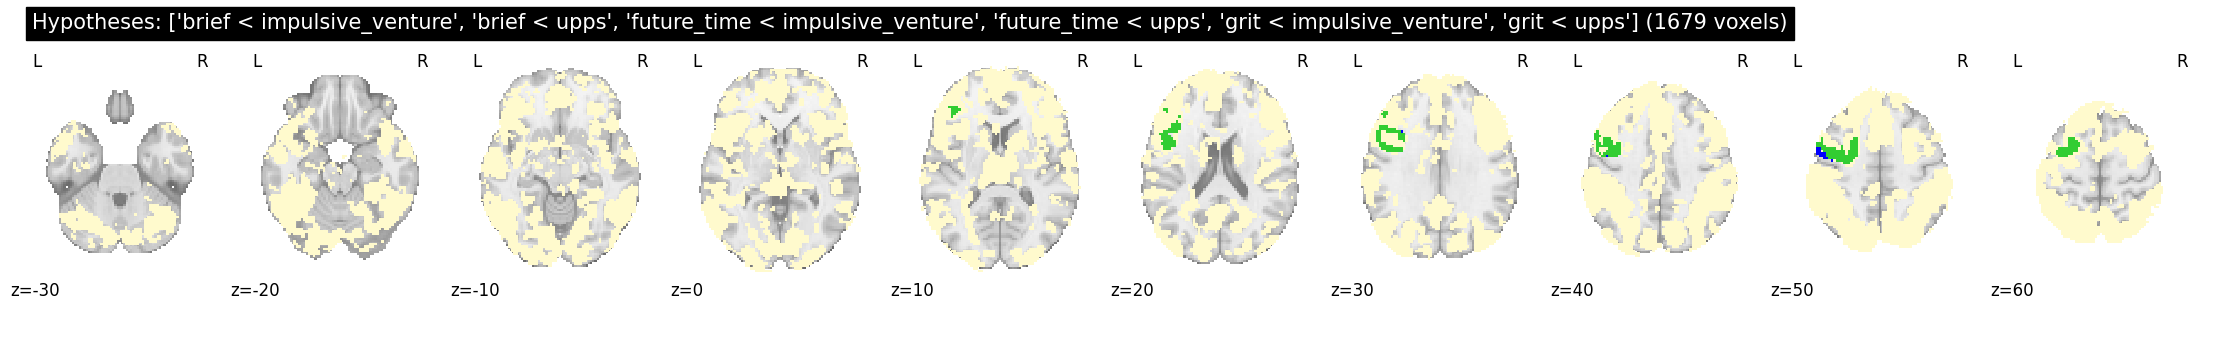

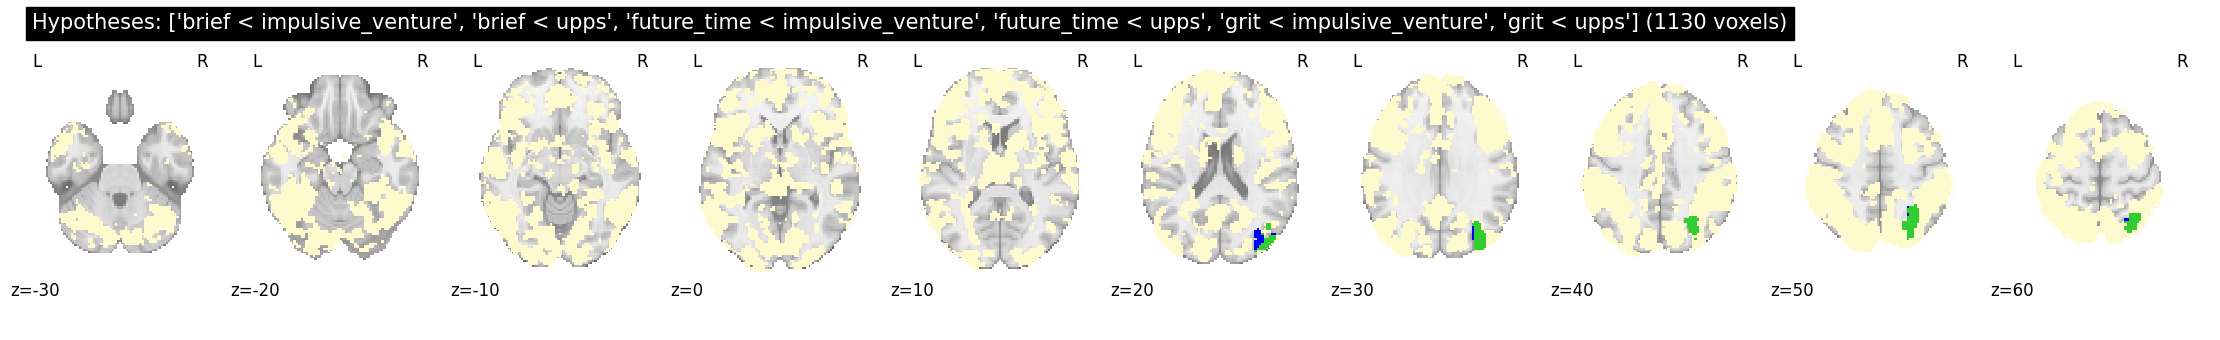

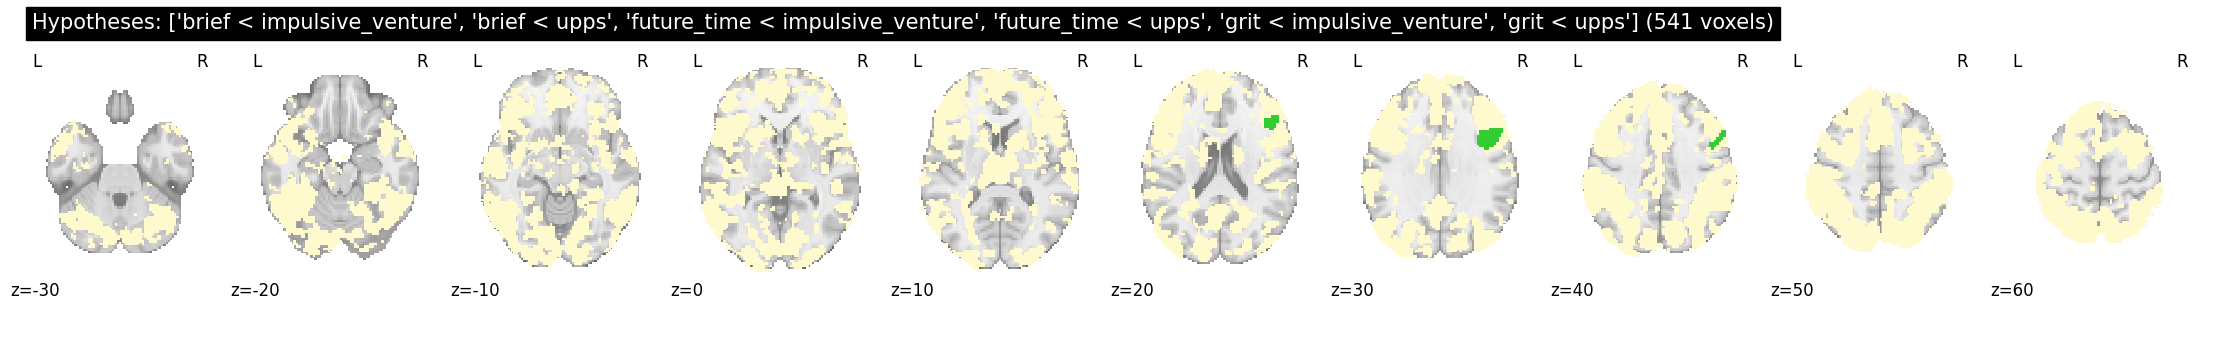

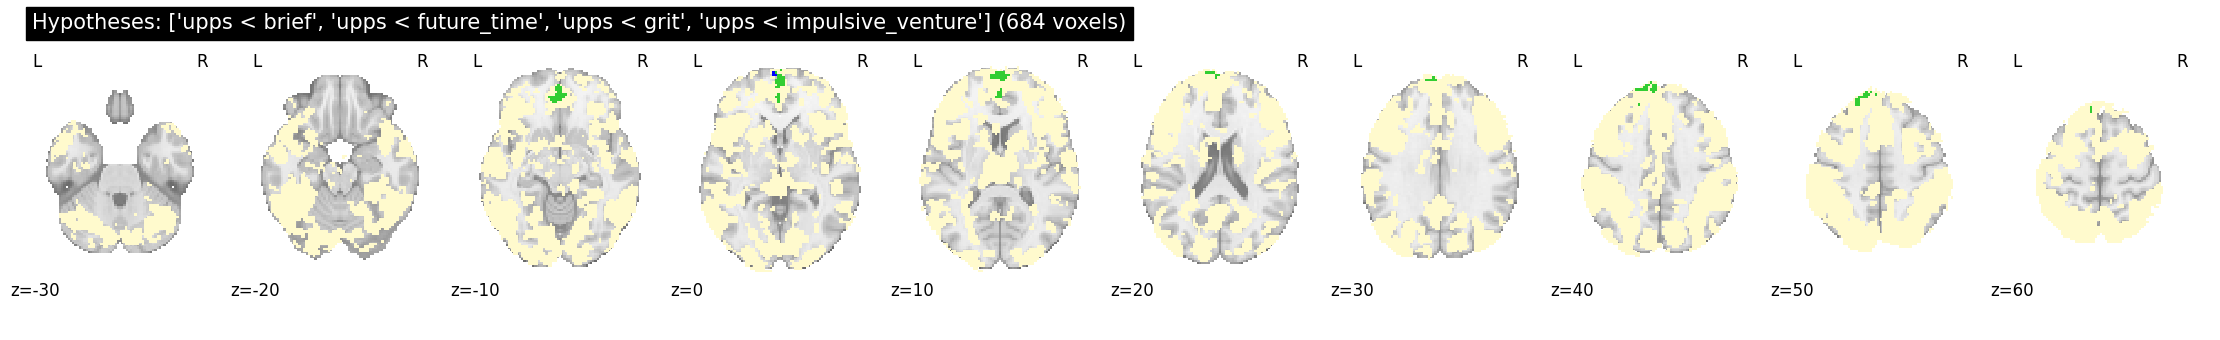

In [10]:
process_pairwise_maps(
    question_tmaps_adjusted,
    question_pmaps_adjusted,
    omnibus_pmap_file_adjusted,
    mask_path,
    z_slices,
    t_threshold=0.05,
    omnibus_f_threshold=0.05,
    min_cluster_vox=400,
)